# Regularization

A major problem with Deep Learning models is overfitting, especially with a small training data set. The model tends to memorize the training data instead of recognizing general patterns that can also be applied to new data.

**You will learn to:** Use regularization in Deep Learning models.

Let's first import the packages you are going to use.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import *
from testCases import *


plt.rcParams['figure.figsize'] = (8, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement:**
You are an advertising representative for the city of Stuttgart and have the task of advertising the next football derby TSVgg Stuttgart-Münster vs. Stuttgarter Kickers as effectively as possible. To do this, you want to put up advertising posters in the city to attract residents to the game. To make your advertising as good as possible, you need to find out in which parts of the city you want to advertise for which team.

<center><img src="images/Stuttgart.png" style="width:900px" /></center>
<caption><center><u><b>Figure 1:</b> Map of Stuttgart</u></center></caption>

In order to find out where to put up which posters, you want to train a machine-learning model using data obtained from a recent survey.
You got the following data from the survey:

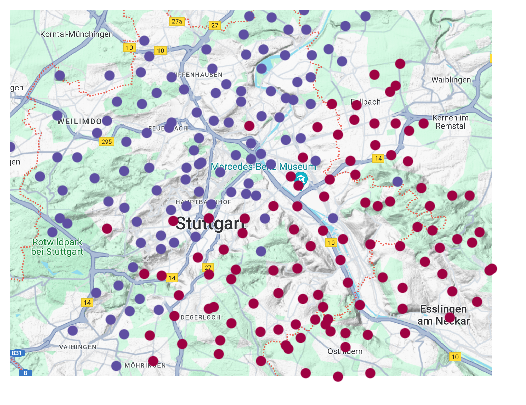

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

The dots represent the place of residence of the people who responded to the survey. The colour of the dot corresponds to the answer they gave to the survey. 
**Your goal** is to find out which parts of the city are dominated by TSVgg Stuttgart-Münster (blue) fans and which parts are inhabited by mostly Stuttgarter Kickers fans (red). 

The dataset provided is noisy, but at first glance can be divided into two areas with TSVgg Stuttgart-Münster fans and a part inhabited by mostly Stuttgarter Kickers fans.

## 1 - Non-regularized model

At first, you want to create a simple model - without any regularization. There, you can see the problems caused by not including regularization in your model. After this, you will learn how regularization can help you create models with better performance on dev and test sets.

You will use the following neural network. It is already implemented without regularization and can be easily expanded to include the two regularization methods that we will implement - L2 regularization and dropout.

- When `lambd` is set to a non-zero value, the model uses L2-regularization both when computing the cost and during backward propagation. For the model, we use "`lambd`" because "`lambda`" is a reserved keyword in python.
- When `keep_prob` is assigned a value `0 < keep_prob < 1`, dropout is used as a regularization method.

At first, we will implement L2-Regularization and after that dropout.

In [3]:
def train_model_parameters(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.

    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """

    grads = {}
    costs = []                            # to keep track of the cost
    layers_dims = [X.shape[0], 20, 3, 1]

    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)

        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)

        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout,
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {:.2e}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 6.56e-01
Cost after iteration 10000: 1.63e-01
Cost after iteration 20000: 1.39e-01


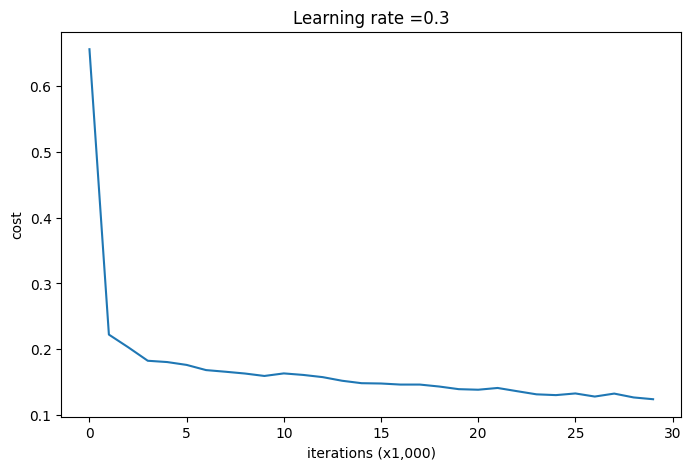

On the training set:
Accuracy: 0.948
On the test set:
Accuracy: 0.915


In [4]:
parameters = train_model_parameters(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (you will observe the impact of regularization on this model). Run the following code to plot the decision boundary of your model.

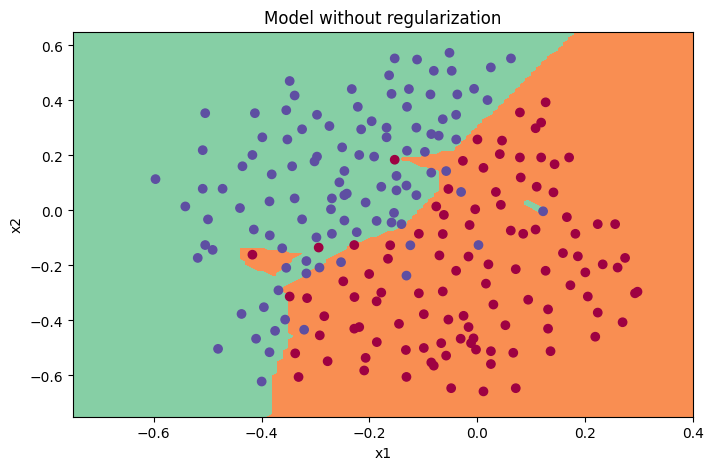

In [5]:
plt.title("Model without regularization")
axes = plt.gca()    # Get the current Axes instance on the current figure
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## 2 - L2 Regularization

The first way to avoid overfitting is called **L2 regularization**. Generally, a model with small weights is simpler than a model with large weights. So with the usage of L2 Regularization, we punish the model for big weights, the neurons can't memorize the training data and the whole model learns a more general solution to our problem.

This is the cost function we used for our non-regularized model:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$

For L2-Regularization, we sum up all the weights of all layers and add it to our cost. The weights are squared to punish weights with bigger values more than those with low values. We use the $hyperparameter\,\lambda$ to modify how much impact the size of the weights should have for our general cost:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

We also need to alter our backward propagation to take into account the regularization cost.

**Exercise**: Implement `compute_cost_with_regularization()` and  `backward_propagation_with_regularization()` for using L2-Regularization. 

To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$, use Broadcasting and note that you have to do this for all $W^{[l]}$.

You may find this numpy function useful:
```python
np.sum(np.square(Wl))
```

In [6]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.

    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model

    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    # This gives you the cross-entropy part of the cost
    cross_entropy_cost = compute_cost(A3, Y)

    ### START CODE HERE ### (approx. 2 line)
    L2_regularization_cost = (lambd / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))

    cost = cross_entropy_cost + L2_regularization_cost
    ### END CODER HERE ###

    return cost


In [7]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = {:.3f}".format(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.786


**Expected Output**: 

**cost**    1.786


With the new cost function, we also need to change our backward propagation. There, we need to add the regularization term's gradient
$$\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2)$$

**Exercise:** Implement the changes for backward propagation. You can use your results from the previous exercise or look into reg_utils.py.
Note: The changes only concern dW1, dW2 and dW3. For each, you need to add the gradient.

In [ ]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.

    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar

    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """

    m = X.shape[1]
    (A1, W1, A2, W2, A3, W3) = cache

    dZ3 = A3 - Y

    # Note: d/dW * (1/2 * lambd/m * W²) = lambd / m * W

    # calculate dW3 and db3 using dZ3
    ### START CODE HERE ### (approx. 2 line)
    dW3 = (1 / m) * np.dot(dZ3, A2.T) + (lambd / m) * W3
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    ### END CODE HERE ###

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))    # The second part is the derivation of the ReLU function.
    # calculate dW2 and db2 using dZ2
    ### START CODE HERE ### (approx. 2 line)
    dW2 = (1 / m) * np.dot(dZ2, A1.T) + (lambd / m) * W2
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    ### END CODE HERE ###

    # calculate dZ1
    # calculate dW1 and db1 using dZ1
    ### START CODE HERE ### (approx. 4 line)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))

    dW1 = (1 / m) * np.dot(dZ1, X.T) + (lambd / m) * W1
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###

    gradients = {"dW3": dW3, "db3": db3,
                 "dW2": dW2, "db2": db2,
                 "dW1": dW1, "db1": db1}

    return gradients

In [9]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


**Expected Output**:

```
dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]
```

Let's now run the model with L2 regularization $(\lambda = 0.7)$. The `train_model_parameters()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

Cost after iteration 0: 6.97e-01
Cost after iteration 10000: 2.68e-01
Cost after iteration 20000: 2.68e-01


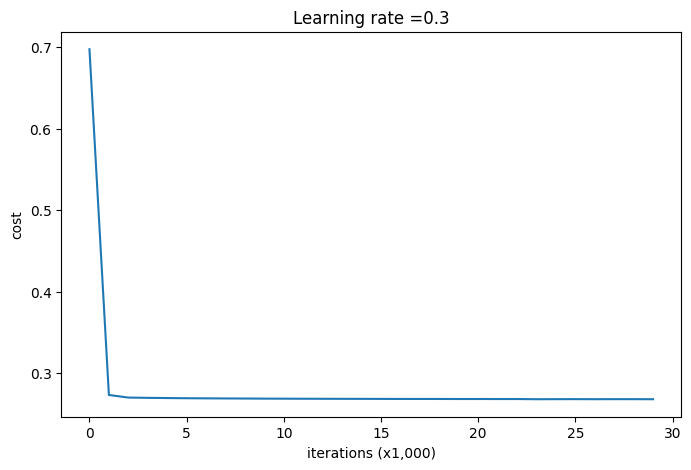

On the train set:
Accuracy: 0.938
On the test set:
Accuracy: 0.930


In [10]:
parameters = train_model_parameters(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Congrats, the test set accuracy increased to 93%. You have made an easier marketing possible!

You are not overfitting the training data anymore. Let's plot the decision boundary.

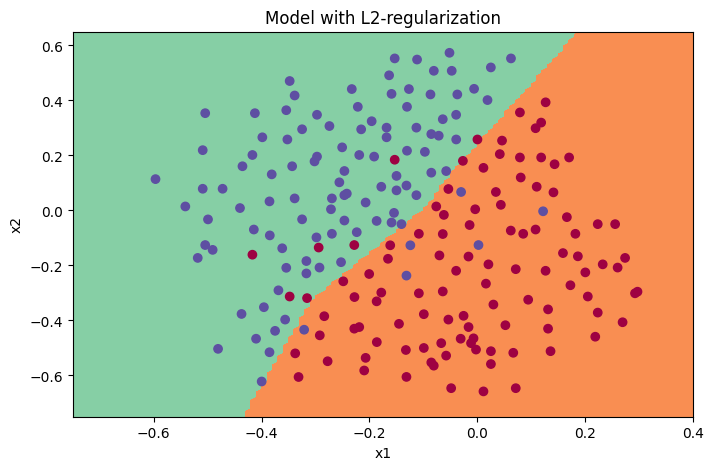

In [11]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with an underfitting problem.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

<font color='red'>
**What you should remember**

The implications of L2-regularization on:

- The cost computation:
    - A regularization term is added to the cost
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices
- Weights end up smaller ("weight decay"):
    - Weights are pushed to smaller values.

## 3 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** 


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

### 3.1 - Forward propagation with dropout

**Exercise**: Implement the forward propagation with dropout. You are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. In lecture, we dicussed creating a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, you will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 1 with probability (`keep_prob`), and 0 otherwise.

**Hint:** Let's say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.
This python statement:  
`X = (X < keep_prob).astype(int)`  

is conceptually the same as this if-else statement (for the simple case of a one-dimensional array) :

```
for i,v in enumerate(x):
    if v < keep_prob:
        x[i] = 1
    else: # v >= keep_prob
        x[i] = 0
```
Note that the `X = (X < keep_prob).astype(int)` works with multi-dimensional arrays, and the resulting output preserves the dimensions of the input array.

Also note that without using `.astype(int)`, the result is an array of booleans `True` and `False`, which Python automatically converts to 1 and 0 if we multiply it with numbers.  (However, it's better practice to convert data into the data type that we intend, so try using `.astype(int)`.)

3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (You are shutting down some neurons). You can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this you are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [12]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.

    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar

    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """

    np.random.seed(1)

    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    # Steps 1-4 as described above.
    ### START CODE HERE ### (approx. 4 lines)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = np.where(D1 < keep_prob, 1, 0)

    A1 = A1 * D1
    A1 = A1 / keep_prob
    ### END CODE HERE ###

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    # Steps 1-4 as described above.
    ### START CODE HERE ### (approx. 4 lines)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = np.where(D2 < keep_prob, 1, 0)

    A2 = A2 * D2
    A2 = A2 / keep_prob
    ### END CODE HERE ###

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    cache = (D1, A1, W1, D2, A2, W2, A3, W3)

    return A3, cache

In [13]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


**Expected Output**: 



A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]



### 3.2 - Backward propagation with dropout

**Exercise**: Implement the backward propagation with dropout. As before, you are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks $D^{[1]}$ and $D^{[2]}$ stored in the cache. 

**Instruction**:
Backpropagation with dropout is actually quite easy. You will have to carry out 2 Steps:
1. You had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, you will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, you had divided `A1` by `keep_prob`. In backpropagation, you'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).


In [14]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.

    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar

    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """

    m = X.shape[1]
    (D1, A1, W1, D2, A2, W2, A3, W3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    ### END CODE HERE ###
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    ### START CODE HERE ### (≈ 2 lines of code)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    ### END CODE HERE ###
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dW3": dW3, "db3": db3,
                 "dW2": dW2, "db2": db2,
                 "dW1": dW1, "db1": db1}

    return gradients

In [15]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dW1 = \n" + str(gradients["dW1"]))
print ("dW2 = \n" + str(gradients["dW2"]))

dW1 = 
[[0.00019884 0.00028657 0.00012138]
 [0.00035647 0.00051375 0.00021761]]
dW2 = 
[[-0.00256518 -0.0009476 ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


**Expected Output**: 

```
dW1 = 
[[0.00019884 0.00028657 0.00012138]
 [0.00035647 0.00051375 0.00021761]]
dW2 = 
[[-0.00256518 -0.0009476 ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
```

Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 14% probability. The function `train_model_parameters()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

Cost after iteration 0: 6.54e-01


c:\Data\DHBW\ML\3_Improving_ML_applications\regularization\reg_utils.py:211: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
c:\Data\DHBW\ML\3_Improving_ML_applications\regularization\reg_utils.py:211: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 10000: 6.10e-02
Cost after iteration 20000: 6.06e-02


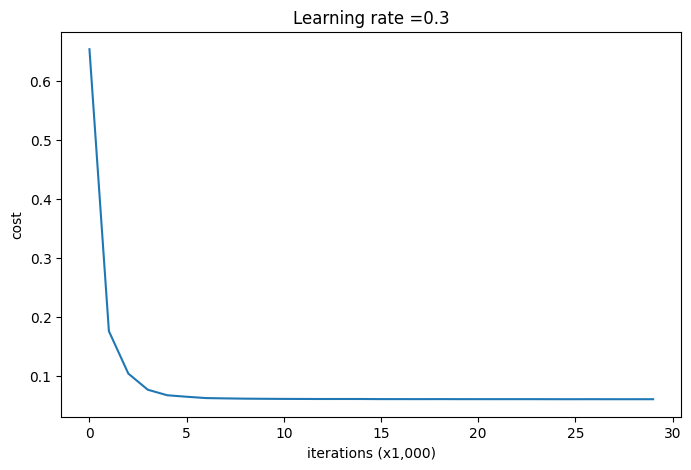

On the train set:
Accuracy: 0.929
On the test set:
Accuracy: 0.950


In [16]:
parameters = train_model_parameters(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)! Your model is not overfitting the training set and does a great job on the test set. The football advertiser will be forever grateful!

Run the code below to plot the decision boundary.

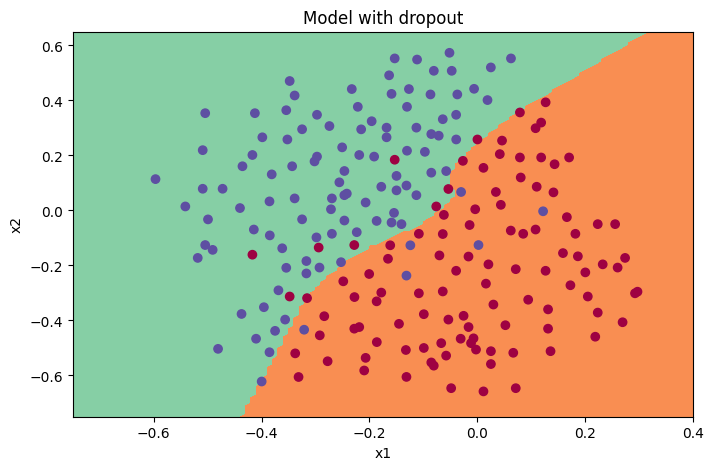

In [17]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Note**:
- A **common mistake** when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training. 
- Deep learning frameworks like [tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [keras](https://keras.io/layers/core/#dropout) or [caffe](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) come with a dropout layer implementation. Don't stress - you will soon learn some of these frameworks.

<font color='red'>
What you should remember about dropout:

- Dropout is a regularization technique.

- You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.

- Apply dropout both during forward and backward propagation.

- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.  

## 4 - Conclusions

**Here are the results of our three models**: 

**model** / **train accuracy** / **test accuracy**


3-layer NN without regularization / 95% / 91.5%

3-layer NN with L2-regularization / 94% / 93%

3-layer NN with dropout / 93% / 95%


Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping your system. 

Congratulations for finishing this assignment! And also for revolutionizing football advertising. :-)

<font color='red'>
What we want you to remember from this notebook:

- Regularization will help you reduce overfitting.

- Regularization will drive your weights to lower values.

- L2 regularization and Dropout are two very effective regularization techniques.

This exercise is based on the respective problem sets in the Deep Learning Specialization from deeplearning.ai (https://www.coursera.org/specializations/deep-learning).
Additional input was provided by Max Triebel and Niklas Ziller, DHBW 2024.